In [ ]:
import os
os.makedirs("/content/drive", exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/cs3244')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, precision_recall_curve,
    average_precision_score, f1_score, auc, precision_score, recall_score
)
from sklearn.model_selection import StratifiedKFold

# from functions_ver2 import data_pipeline as data_pipeline_v2
from functions import data_pipeline


/workspaces/CS3244_ML_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Label Encoding

In [2]:
X_train_std_la, y_train_la, X_test_std_la, y_test_la = data_pipeline('label')

Loading data
Splitting data
Total unique accounts: 45985. Starting to find cutoff point
Cutoff month where CDF reaches 80%: -10

=== Split based on CDF 80% cutoff ===
Cutoff month: -10 (10 months ago)
Old accounts (≤ month -10): 37,210 (80.9%)
New accounts (> month -10): 8,775 (19.1%)
Ratio (old/new): 4.2405
Splitting raw credit records
Cleaning old accounts credit records - [Length: 996586]


/workspaces/CS3244_ML_Project/functions.py:251: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({


Cleaning new accounts credit records - [Length: 51989]


/workspaces/CS3244_ML_Project/functions.py:251: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({


Cleaning credit data completed
Splitting application dataset
Cleaning old accounts application records - [Length: (29264, 18)]
Cleaning new accounts appplication records, - [Length: (7193, 18)]
Merging data
Engineering target variable to label data
Completed old accounts labelling
Completed new accounts labelling
Old accounts: (37210, 3)
New accounts: (8775, 3)
Old threshold: 0.0
New threshold: 0.0
Merging cleaned application and credit records
Train shape: (29264, 23)
Test shape: (7193, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29264 entries, 0 to 29263
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           29264 non-null  int64  
 1   flag_own_car                 29264 non-null  int64  
 2   flag_own_realty              29264 non-null  int64  
 3   cnt_children                 29264 non-null  int64  
 4   flag_mobil                   29264 non-nu

## Using one-hot encoding

In [ ]:
X_train_std_ohe, y_train_ohe, X_test_std_ohe, y_test_ohe = data_pipeline('onehot')

Loading data
Using Colab cache for faster access to the 'credit-card-approval-prediction' dataset.
Using Colab cache for faster access to the 'credit-card-approval-prediction' dataset.
Splitting data
Total unique accounts: 45985. Starting to find cutoff point
Cutoff month where CDF reaches 80%: -10

=== Split based on CDF 80% cutoff ===
Cutoff month: -10 (10 months ago)
Old accounts (≤ month -10): 37,210 (80.9%)
New accounts (> month -10): 8,775 (19.1%)
Ratio (old/new): 4.2405
Splitting raw credit records
Cleaning old accounts credit records - [Length: 996586]
Cleaning new accounts credit records - [Length: 51989]
Cleaning credit data completed
Splitting application dataset
Cleaning old accounts application records - [Length: (29264, 18)]
Cleaning new accounts appplication records, - [Length: (7193, 18)]
Encoding
Encoders: {'name_income_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_education_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False),

In [ ]:
def get_n_components(X_train, method="default"):
    pca = PCA()
    pca.fit(X_train)
    explained_var_ratio = pca.explained_variance_ratio_

    if method == "avg":
        avg_var = 1 / len(explained_var_ratio)
        optimal_components = np.sum(explained_var_ratio > avg_var)

    elif method == "elbow":
        diffs = np.diff(explained_var_ratio)
        elbow_idx = np.argmax(diffs * -1) + 1
        optimal_components = elbow_idx

    elif method == "cumulative":
        cum_var = np.cumsum(explained_var_ratio)
        optimal_components = np.argmax(cum_var >= 0.95) + 1

    else:
        optimal_components = None
    return optimal_components


def build_knn_pipeline(pca_components=None, pca_method='default', sampling_method='smote', random_state=42):

    steps = []

    if sampling_method:
        sampler_map = {
            'smote': SMOTE(random_state=random_state),
            'smotetomek': SMOTETomek(random_state=random_state),
            'cc': ClusterCentroids(random_state=random_state)
        }
        steps.append(('sampling', sampler_map[sampling_method.lower()]))

    if pca_method == 'default' or pca_components is None:
        steps.append(('pca', PCA(whiten=True, random_state=random_state)))
    else:
        steps.append(('pca', PCA(n_components=pca_components, whiten=True, random_state=random_state)))

    steps.append(('knn', KNeighborsClassifier()))

    pipeline_cls = ImbPipeline if sampling_method else Pipeline
    pipeline = pipeline_cls(steps)

    return pipeline


def tune_knn_pipeline(pipeline, X_train, y_train, param_grid, cv=3, scoring='f1', n_jobs=-1):
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_


def evaluate_and_plot(best_model, X_test, y_test, method_name='best'):
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    results = {
        'test_f1': f1_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_proba),
        'test_ap': average_precision_score(y_test, y_proba),
        'test_pr_auc': pr_auc,
        'classification_report': classification_report(y_test, y_pred, digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    return results

knn_param_grid = {
        'knn__n_neighbors': [3, 5, 7, 9, 11],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'minkowski', 'manhattan']
    }

def model_pipeline_knn_pca(
    X_train, y_train, X_test=None, y_test=None,
    n_splits=5, random_state=42,
    pca_method='default', sampling_method=None
):

    print(f"\nStarting PCA+KNN pipeline ({'Base' if sampling_method is None else sampling_method.upper()})")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_models, f1_scores, roc_scores, pr_auc_scores = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        components = get_n_components(X_tr, method=pca_method)

        pipeline = build_knn_pipeline(
            pca_components=components,
            pca_method=pca_method,
            sampling_method=sampling_method,
            random_state=random_state
        )

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1]

        f1 = f1_score(y_val, y_pred)
        roc = roc_auc_score(y_val, y_proba)
        pr_auc = average_precision_score(y_val, y_proba)

        f1_scores.append(f1)
        roc_scores.append(roc)
        pr_auc_scores.append(pr_auc)
        fold_models.append(pipeline)

        # print(f"Fold {fold}: n_components={components}, "
        #       f"F1={f1:.3f}, ROC-AUC={roc:.3f}, PR-AUC={pr_auc:.3f}")

    best_fold_idx = int(np.argmax(f1_scores))
    best_model = fold_models[best_fold_idx]

    print(f"\nBest fold selected: Fold {best_fold_idx+1} "
          f"(F1={f1_scores[best_fold_idx]:.3f}, "
          f"ROC-AUC={roc_scores[best_fold_idx]:.3f}, "
          f"PR-AUC={pr_auc_scores[best_fold_idx]:.3f})")

    results = {
        'f1': np.mean(f1_scores),
        'roc_auc': np.mean(roc_scores),
        'pr_auc': np.mean(pr_auc_scores),
        'n_components': components,
        'best_fold_idx': best_fold_idx
    }

    if X_test is not None and y_test is not None:
        test_results = evaluate_and_plot(best_model, X_test, y_test, method_name=pca_method)
        results.update(test_results)

        print(f"\nTest set → F1={results['test_f1']:.3f}, "
              f"ROC-AUC={results['test_roc_auc']:.3f}, "
              f"PR-AUC={results['test_ap']:.3f}")

    return results, best_model




In [ ]:
def run_knn_model(X_train, y_train, X_test, y_test, random_state=42):
    sampling_methods = ['smote', 'smotetomek', 'cc']
    train_summary, test_summary = [], []

    for method in sampling_methods:
        method_name = method.upper()
        print(f"\n{'='*70}\nRunning {method_name} Sampling Method Model\n{'='*70}")

        res, best_model = model_pipeline_knn_pca(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            pca_method='default',
            sampling_method=method,
            random_state=random_state
        )

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        print(f"\n--- Classification Report (Train) | {method_name} ---")
        print(classification_report(y_train, y_pred_train, digits=3))

        print(f"\n--- Classification Report (Test) | {method_name} ---")
        print(classification_report(y_test, y_pred_test, digits=3))

        train_summary.append({
            "Method": method_name,
            "F1 (Train)": res.get('f1', None),
            "ROC-AUC (Train)": res.get('roc_auc', None),
            "PR-AUC (Train)": res.get('pr_auc', None)
        })

        test_summary.append({
            "Method": method_name,
            "F1 (Test)": res.get('test_f1', None),
            "ROC-AUC (Test)": res.get('test_roc_auc', None),
            "PR-AUC (Test)": res.get('test_ap', None)
        })

    df_train = pd.DataFrame(train_summary).sort_values(by="F1 (Train)", ascending=False).reset_index(drop=True)
    df_test = pd.DataFrame(test_summary).sort_values(by="F1 (Test)", ascending=False).reset_index(drop=True)

    print("\n\n================ TRAIN PERFORMANCE SUMMARY ================\n")
    print(df_train[["Method", "F1 (Train)", "ROC-AUC (Train)", "PR-AUC (Train)"]].to_string(index=False))

    print("\n\n================ TEST PERFORMANCE SUMMARY ================\n")
    print(df_test[["Method", "F1 (Test)", "ROC-AUC (Test)", "PR-AUC (Test)"]].to_string(index=False))

    best_method = df_test.iloc[0]["Method"]
    best_test_f1 = df_test.iloc[0]["F1 (Test)"]
    best_test_roc = df_test.iloc[0]["ROC-AUC (Test)"]
    best_test_pr = df_test.iloc[0]["PR-AUC (Test)"]

    print(f"\nBest Model (by Test F1): {best_method} → "
          f"F1={best_test_f1:.3f}, ROC-AUC={best_test_roc:.3f}, PR-AUC={best_test_pr:.3f}")

    return df_train, df_test


In [ ]:
def evaluate_model_on_train_test(model, X_train, y_train, X_test, y_test, label):

    print("\n========== CONFUSION MATRICES & CLASSIFICATION REPORTS==========")
    # --- Train predictions ---
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --- Confusion matrices ---
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # --- Classification reports ---
    report_train = classification_report(y_train, y_pred_train, digits=3)
    report_test = classification_report(y_test, y_pred_test, digits=3)

    # --- Print results ---
    print(f"\n[{label} - TRAIN SET]")
    print("Confusion Matrix:\n", cm_train)
    ConfusionMatrixDisplay(cm_train).plot(cmap='Blues')
    plt.title(f"{label} - Train Confusion Matrix")
    plt.show()
    print("Classification Report:\n", report_train)

    print(f"\n[{label} - TEST SET]")
    print("Confusion Matrix:\n", cm_test)
    ConfusionMatrixDisplay(cm_test).plot(cmap='Oranges')
    plt.title(f"{label} - Test Confusion Matrix")
    plt.show()
    print("Classification Report:\n", report_test)

## Base Model with No Sampling or PCA

========== BASE MODEL COMPARISON (Label Encoded vs One-Hot Encoded) ==========

Starting PCA+KNN pipeline (Base)

Best fold selected: Fold 3 (F1=0.188, ROC-AUC=0.573, PR-AUC=0.267)

Test set → F1=0.131, ROC-AUC=0.533, PR-AUC=0.140

========== CONFUSION MATRICES & CLASSIFICATION REPORTS==========

[Label Encoded - TRAIN SET]
Confusion Matrix:
 [[23141   671]
 [ 4359  1093]]


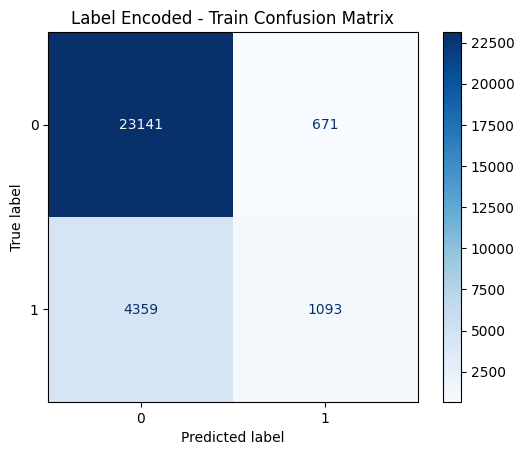

Classification Report:
               precision    recall  f1-score   support

           0      0.841     0.972     0.902     23812
           1      0.620     0.200     0.303      5452

    accuracy                          0.828     29264
   macro avg      0.731     0.586     0.602     29264
weighted avg      0.800     0.828     0.790     29264


[Label Encoded - TEST SET]
Confusion Matrix:
 [[5912  370]
 [ 821   90]]


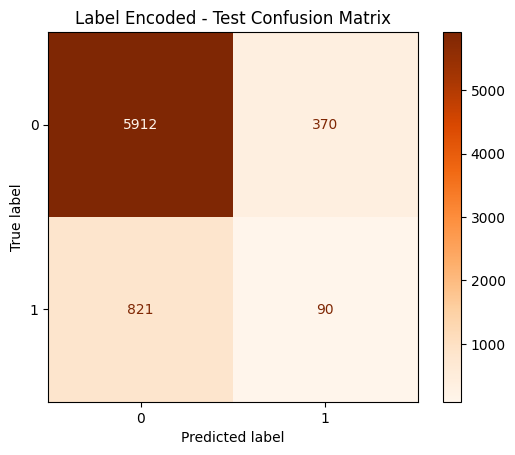

Classification Report:
               precision    recall  f1-score   support

           0      0.878     0.941     0.908      6282
           1      0.196     0.099     0.131       911

    accuracy                          0.834      7193
   macro avg      0.537     0.520     0.520      7193
weighted avg      0.792     0.834     0.810      7193


Starting PCA+KNN pipeline (Base)

Best fold selected: Fold 2 (F1=0.165, ROC-AUC=0.573, PR-AUC=0.249)

Test set → F1=0.103, ROC-AUC=0.531, PR-AUC=0.146

========== CONFUSION MATRICES & CLASSIFICATION REPORTS==========

[One-Hot Encoded - TRAIN SET]
Confusion Matrix:
 [[23136   676]
 [ 4436  1016]]


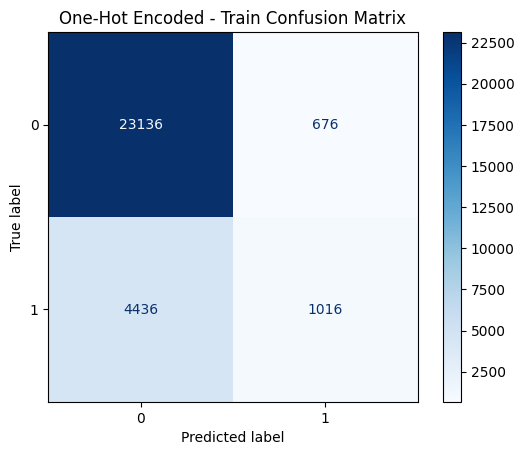

Classification Report:
               precision    recall  f1-score   support

           0      0.839     0.972     0.901     23812
           1      0.600     0.186     0.284      5452

    accuracy                          0.825     29264
   macro avg      0.720     0.579     0.592     29264
weighted avg      0.795     0.825     0.786     29264


[One-Hot Encoded - TEST SET]
Confusion Matrix:
 [[5946  336]
 [ 843   68]]


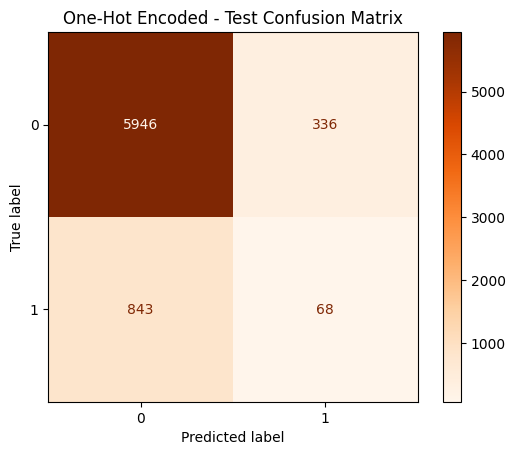

Classification Report:
               precision    recall  f1-score   support

           0      0.876     0.947     0.910      6282
           1      0.168     0.075     0.103       911

    accuracy                          0.836      7193
   macro avg      0.522     0.511     0.507      7193
weighted avg      0.786     0.836     0.808      7193


Base Model Results Comparison:
Metric           Label_Train   Label_Test    OHE_Train     OHE_Test
----------------------------------------------------------------------
f1                     0.172        0.131        0.157        0.103
roc_auc                0.570        0.533        0.560        0.531
pr_auc                 0.252        0.140        0.241        0.146


In [ ]:
print("========== BASE MODEL COMPARISON (Label Encoded vs One-Hot Encoded) ==========")

# --- (Label Encoded) ---
base_results_label, base_model_label = model_pipeline_knn_pca(
    X_train_std_la, y_train_la,
    X_test_std_la, y_test_la,
    sampling_method=None,
    pca_method='default'
)

evaluate_model_on_train_test(
    base_model_label, X_train_std_la, y_train_la, X_test_std_la, y_test_la,
    label="Label Encoded"
)

# --- (One-Hot Encoded) ---
base_results_ohe, base_model_ohe = model_pipeline_knn_pca(
    X_train_std_ohe, y_train_ohe,
    X_test_std_ohe, y_test_ohe,
    sampling_method=None,
    pca_method='default'
)

evaluate_model_on_train_test(
    base_model_ohe, X_train_std_ohe, y_train_ohe, X_test_std_ohe, y_test_ohe,
    label="One-Hot Encoded"
)

# --- Print Train vs Test Results ---
print("\nBase Model Results Comparison:")
print(f"{'Metric':<15} {'Label_Train':>12} {'Label_Test':>12} {'OHE_Train':>12} {'OHE_Test':>12}")
print("-" * 70)

metric_pairs = [
    ('f1', 'test_f1'),
    ('roc_auc', 'test_roc_auc'),
    ('pr_auc', 'test_ap')
]

for train_m, test_m in metric_pairs:
    label_train = base_results_label.get(train_m, float('nan'))
    label_test = base_results_label.get(test_m, float('nan'))
    ohe_train = base_results_ohe.get(train_m, float('nan'))
    ohe_test = base_results_ohe.get(test_m, float('nan'))

    print(f"{train_m:<15} {label_train:>12.3f} {label_test:>12.3f} {ohe_train:>12.3f} {ohe_test:>12.3f}")


**Observations**

The Label Encoded model slightly outperformed the One-Hot Encoded model across most metrics, particularly in F1-score (+0.015 train, +0.028 test) and PR-AUC (+0.011 train).

However, PR-AUC on the test set is nearly identical (0.140 vs 0.146), suggesting both encodings yield similar ranking performance in distinguishing the positive class.

The modest F1 and ROC-AUC values (F1 < 0.2, ROC-AUC ≈ 0.55–0.57) indicate that the base KNN model struggles to capture class separation effectively without sampling or dimensionality reduction.

**Conclusion**

Label encoding provides slightly better generalization in this baseline setup. However, both approaches show limited predictive power, likely due to class imbalance and high feature dimensionality.

## Comparing Sampling Methods

In [ ]:
print("========== SAMPLING METHODS COMPARISON ==========")

# Run all sampling methods
df_train_sampling, df_test_sampling = run_knn_model(
    X_train_std_la, y_train_la,
    X_test_std_la, y_test_la,
    random_state=42
)

# Identify best sampling method by Test F1
best_sampling_method = (
    df_test_sampling.iloc[0]["Method"].lower()
    if df_test_sampling.iloc[0]["Method"] != "Base"
    else None
)

print(f"\nBest Sampling Method Selected: {best_sampling_method.upper() if best_sampling_method else 'BASE'}")


========== SAMPLING METHODS COMPARISON ==========

Running SMOTE Sampling Method Model

Starting PCA+KNN pipeline (SMOTE)

Best fold selected: Fold 2 (F1=0.272, ROC-AUC=0.566, PR-AUC=0.234)

Test set → F1=0.182, ROC-AUC=0.526, PR-AUC=0.133

--- Classification Report (Train) | SMOTE ---
              precision    recall  f1-score   support

           0      0.870     0.864     0.867     23812
           1      0.424     0.437     0.430      5452

    accuracy                          0.785     29264
   macro avg      0.647     0.650     0.649     29264
weighted avg      0.787     0.785     0.786     29264


--- Classification Report (Test) | SMOTE ---
              precision    recall  f1-score   support

           0      0.877     0.748     0.807      6282
           1      0.137     0.274     0.182       911

    accuracy                          0.688      7193
   macro avg      0.507     0.511     0.495      7193
weighted avg      0.783     0.688     0.728      7193


Running SMOT

## Comparing PCA Methods using best sampling method

In [ ]:
print("========== PCA METHODS COMPARISON ==========")

pca_methods = ["default", "avg", "elbow", "cumulative"]
pca_summary = []

for method in pca_methods:
    print(f"\nRunning PCA Method: {method.upper()}")
    res, model = model_pipeline_knn_pca(
        X_train_std_la, y_train_la,
        X_test_std_la, y_test_la,
        sampling_method="cc",
        pca_method=method
    )
    pca_summary.append({
        "PCA Method": method,
        "F1 (Train)": res["f1"],
        "ROC-AUC (Train)": res["roc_auc"],
        "PR-AUC (Train)": res["pr_auc"],
        "F1 (Test)": res["test_f1"],
        "ROC-AUC (Test)": res["test_roc_auc"],
        "PR-AUC (Test)": res["test_ap"]
    })

df_pca = pd.DataFrame(pca_summary).sort_values(by="F1 (Test)", ascending=False).reset_index(drop=True)
print("\n\n================ PCA PERFORMANCE SUMMARY ================\n")
print(df_pca.to_string(index=False))

best_pca_method = df_pca.iloc[0]["PCA Method"]
print(f"\nBest PCA Method Selected: {best_pca_method.upper()}")


========== PCA METHODS COMPARISON ==========

Running PCA Method: DEFAULT

Starting PCA+KNN pipeline (CC)

Best fold selected: Fold 3 (F1=0.303, ROC-AUC=0.537, PR-AUC=0.203)

Test set → F1=0.215, ROC-AUC=0.515, PR-AUC=0.130

Running PCA Method: AVG

Starting PCA+KNN pipeline (CC)

Best fold selected: Fold 2 (F1=0.302, ROC-AUC=0.538, PR-AUC=0.202)

Test set → F1=0.224, ROC-AUC=0.538, PR-AUC=0.138

Running PCA Method: ELBOW

Starting PCA+KNN pipeline (CC)

Best fold selected: Fold 2 (F1=0.299, ROC-AUC=0.526, PR-AUC=0.197)

Test set → F1=0.215, ROC-AUC=0.516, PR-AUC=0.130

Running PCA Method: CUMULATIVE

Starting PCA+KNN pipeline (CC)

Best fold selected: Fold 5 (F1=0.300, ROC-AUC=0.534, PR-AUC=0.202)

Test set → F1=0.211, ROC-AUC=0.506, PR-AUC=0.129


================ PCA PERFORMANCE SUMMARY ================

PCA Method  F1 (Train)  ROC-AUC (Train)  PR-AUC (Train)  F1 (Test)  ROC-AUC (Test)  PR-AUC (Test)
       avg    0.293458         0.523455        0.196499   0.223803        0.537564 

## Best PCA Method - AVG with Clustering Centeroids Sampling Method

## Hyperparameter Tuning

In [ ]:
print("========== HYPERPARAMETER TUNING ==========")

from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label=1)

components = get_n_components(X_train_std_la, method=best_pca_method)
pipeline = build_knn_pipeline(
    pca_components=components,
    pca_method=best_pca_method,
    sampling_method=best_sampling_method
)

knn_param_grid = {
        'knn__n_neighbors': [3, 5, 7, 9, 11],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'minkowski', 'manhattan']
}

best_pipeline, best_params = tune_knn_pipeline(
    pipeline, X_train_std_la, y_train_la,
    knn_param_grid, cv=3, scoring='f1'
)

print("\nBest Hyperparameters Found:")
for k, v in best_params.items():
    print(f"{k}: {v}")


========== HYPERPARAMETER TUNING ==========

Best Hyperparameters Found:
knn__metric: manhattan
knn__n_neighbors: 5
knn__weights: uniform


### Retriving the Best Model

In [ ]:
# Make predictions

y_train_pred = best_pipeline.predict(X_train_std_la)
y_test_pred = best_pipeline.predict(X_test_std_la)

# Evaluate
print("Train Classification Report:")
print(classification_report(y_train_la, y_train_pred, digits=3))

print("\nTest Classification Report:")
print(classification_report(y_test_la, y_test_pred, digits=3))


Train Classification Report:
              precision    recall  f1-score   support

           0      0.887     0.503     0.642     23812
           1      0.249     0.720     0.370      5452

    accuracy                          0.543     29264
   macro avg      0.568     0.611     0.506     29264
weighted avg      0.768     0.543     0.591     29264


Test Classification Report:
              precision    recall  f1-score   support

           0      0.884     0.483     0.624      6282
           1      0.136     0.563     0.220       911

    accuracy                          0.493      7193
   macro avg      0.510     0.523     0.422      7193
weighted avg      0.789     0.493     0.573      7193



In [ ]:

print("========== FINAL EVALUATION ON TEST SET ==========")

final_results = evaluate_and_plot(best_pipeline, X_test_std_la, y_test_la, method_name="Final")

print("\nFinal Test Results:")
print(f"F1 = {final_results['test_f1']:.3f}")
print(f"ROC-AUC = {final_results['test_roc_auc']:.3f}")
print(f"PR-AUC = {final_results['test_pr_auc']:.3f}")

print("\nClassification Report:")
print(final_results['classification_report'])

print("\nConfusion Matrix:")
print(final_results['confusion_matrix'])


========== FINAL EVALUATION ON TEST SET ==========

Final Test Results:
F1 = 0.220
ROC-AUC = 0.528
PR-AUC = 0.180

Classification Report:
              precision    recall  f1-score   support

           0      0.884     0.483     0.624      6282
           1      0.136     0.563     0.220       911

    accuracy                          0.493      7193
   macro avg      0.510     0.523     0.422      7193
weighted avg      0.789     0.493     0.573      7193


Confusion Matrix:
[[3032 3250]
 [ 398  513]]


In [ ]:
def visualize_pca_feature_importance(best_model, X_train, y_train, top_n_features=10, top_n_pcs=5):

    pca_step_name = [name for name in best_model.named_steps if 'pca' in name.lower()][0]
    pca_step = best_model.named_steps[pca_step_name]

    loadings = pd.DataFrame(
        pca_step.components_.T,
        index=X_train.columns,
        columns=[f'PC{i+1}' for i in range(pca_step.n_components_)]
    )
    loadings['importance'] = np.sum(np.abs(loadings), axis=1)
    loadings = loadings.sort_values('importance', ascending=False)

    print("Top features by PCA importance:\n", loadings.head(top_n_features))

    # --- Transform X_train to PCA space ---
    X_pca = pca_step.transform(X_train)
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca_step.n_components_)])
    X_pca_df['label'] = y_train.values

    # --- Correlation of PCs with label ---
    corr_with_label = X_pca_df.drop(columns='label').corrwith(X_pca_df['label']).abs().sort_values(ascending=False)

    # --- Heatmap of top features × all PCs ---
    top_features = loadings.head(top_n_features).index
    loadings_top_features = loadings.loc[top_features, loadings.columns[:-1]]
    loadings_scaled = loadings_top_features.apply(lambda x: x / np.max(np.abs(x)), axis=0)

    plt.figure(figsize=(min(20, pca_step.n_components_*1.5),6))
    sns.heatmap(loadings_scaled, annot=True, cmap='coolwarm', center=0)
    plt.title(f"PCA Loadings (Top {top_n_features} Features)")
    plt.xlabel("Principal Components")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    # --- Barplot of top PCs by correlation with label ---
    top_pcs = corr_with_label.head(top_n_pcs).index
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_pcs, y=corr_with_label[top_pcs])
    plt.ylabel("Absolute correlation with label")
    plt.title(f"Top {top_n_pcs} PCs Correlated with Label")
    plt.show()

    return loadings, corr_with_label

Top features by PCA importance:
                                   PC1       PC2       PC3  importance
occupation_type_encoded      0.987309 -0.148747  0.027938    1.163994
name_income_type_encoded    -0.052284 -0.160419  0.921331    1.134034
age_binned_encoded           0.124180  0.848816  0.138877    1.111873
age                          0.054524  0.366423  0.058655    0.479602
name_education_type_encoded  0.017501  0.086614  0.250075    0.354190
cnt_children                -0.023559 -0.179646  0.024063    0.227269
risk_score                   0.003601  0.034632 -0.179232    0.217465
months_employed             -0.032569  0.051392  0.117189    0.201149
cnt_fam_members_encoded     -0.019548 -0.148765  0.028699    0.197013
amt_income_total_log        -0.018381 -0.022641 -0.124028    0.165050


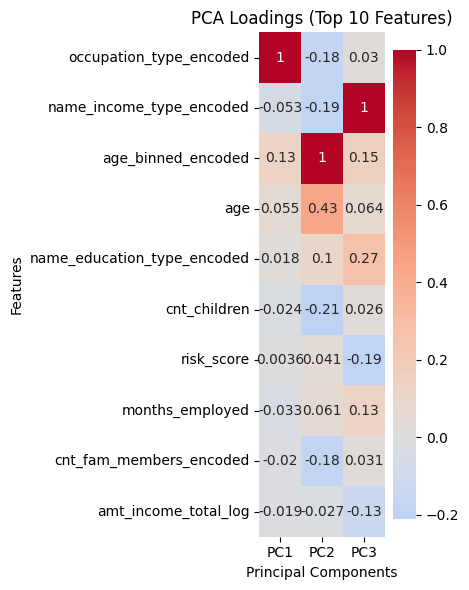

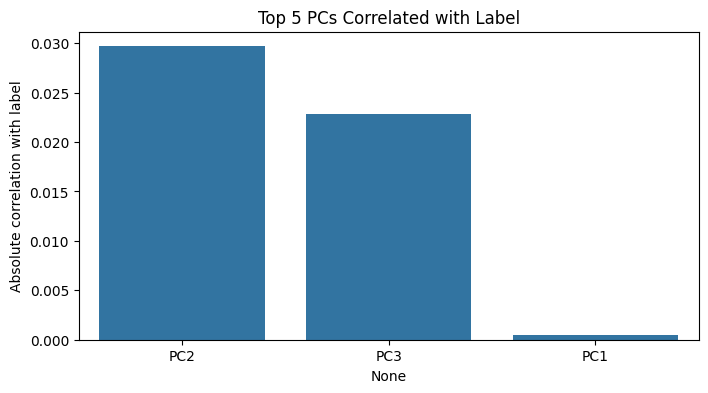

In [ ]:
# Visualize top features and PCs
loadings, corr_with_label = visualize_pca_feature_importance(
    best_pipeline, X_train_std_la, y_train_la,
    top_n_features=10, top_n_pcs=5
)

###

## Using OHE to Get In-Depth Analysis on which Category Contributes Most